# =============================================================================
# STEP 1: IMPORT LIBRARIES AND LOAD DATA
# =============================================================================
# Import necessary libraries for data processing and modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Statistical and time series related libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Load the dataset
try:
    # Adjust the path if needed
    # df = pd.read_csv('bike_data.csv')
    df = pd.read_csv('data/preprocessed/ts_data_15min.csv')
    print(f"Successfully loaded dataset with {len(df)} records")
    
    # Convert date column to datetime
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    df.set_index('dateTime', inplace=True)
    
    # Display basic information
    print("\nDataset Information:")
    print(f"  - Time period: {df.index.min()} to {df.index.max()}")
    print(f"  - Sampling frequency: 15-minute intervals")
    print(f"  - Available columns: {', '.join(df.columns)}")
    print(f"  - Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create some sample data for demonstration if loading fails
    date_rng = pd.date_range(start='2023-01-01', end='2023-01-31', freq='15T')
    df = pd.DataFrame(date_rng, columns=['datetime'])
    df['total_bikes'] = np.random.randint(100, 500, size=len(df))
    df['electrical_bikes'] = np.random.randint(50, 300, size=len(df))
    df['mechanical_bikes'] = df['total_bikes'] - df['electrical_bikes']
    df.set_index('datetime', inplace=True)
    print("Created sample data for demonstration")

Successfully loaded dataset with 22752 records

Dataset Information:
  - Time period: 2018-08-01 00:00:00 to 2019-03-25 23:45:00
  - Sampling frequency: 15-minute intervals
  - Available columns: bikesInUsage, electricalBikesInUsage, mechanicalBikesInUsage
  - Memory usage: 0.69 MB

First 5 rows of the dataset:
                     bikesInUsage  electricalBikesInUsage  \
dateTime                                                    
2018-08-01 00:00:00           NaN                     NaN   
2018-08-01 00:15:00           NaN                     NaN   
2018-08-01 00:30:00           NaN                     NaN   
2018-08-01 00:45:00           NaN                     NaN   
2018-08-01 01:00:00           NaN                     NaN   

                     mechanicalBikesInUsage  
dateTime                                     
2018-08-01 00:00:00                     NaN  
2018-08-01 00:15:00                     NaN  
2018-08-01 00:30:00                     NaN  
2018-08-01 00:45:00          

# STEP 2: DATA PREPROCESSING AND CLEANING

In [3]:
# Check for missing values
print("Checking for missing values...")
missing_values = df.isnull().sum()
print(f"Missing values by column:\n{missing_values}")

# Impute missing values using time-based methods
if missing_values.sum() > 0:
    print("\nImputing missing values...")
    # Create a copy for imputed data
    df_imputed = df.copy()
    
    # For each column with missing values, apply time-appropriate imputation
    for col in df.columns[df.isnull().any()]:
        # Use time-of-day and day-of-week patterns for imputation
        # For each missing value, find the average value for the same time of day and day of week
        values_to_impute = df[col][df[col].isnull()]
        for idx in values_to_impute.index:
            # Get same time of day and day of week
            same_time = df[col][
                (df.index.hour == idx.hour) & 
                (df.index.minute == idx.minute) & 
                (df.index.dayofweek == idx.dayofweek)
            ].dropna()
            # If we have values, use the mean; otherwise use global mean
            if len(same_time) > 0:
                df_imputed.loc[idx, col] = same_time.mean()
            else:
                df_imputed.loc[idx, col] = df[col].mean()
    
    # Rename columns to indicate imputation
    imputed_cols = df.columns[df.isnull().any()]
    for col in imputed_cols:
        imputed_col_name = f"{col}_imputed"
        df_imputed[imputed_col_name] = df_imputed[col]
    
    print(f"Successfully imputed missing values in {len(imputed_cols)} columns")
    
    # Use the imputed DataFrame going forward
    df = df_imputed
else:
    print("No missing values found. Proceeding with original data.")
    # Add _imputed suffix to maintain consistency with later code
    df['total_bikes_imputed'] = df['total_bikes'] if 'total_bikes' in df.columns else df.iloc[:, 0]


Checking for missing values...
Missing values by column:
bikesInUsage              2565
electricalBikesInUsage    2565
mechanicalBikesInUsage    2565
dtype: int64

Imputing missing values...
Successfully imputed missing values in 3 columns


In [4]:
# Check for outliers
print("\nChecking for outliers using z-score method...")
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number]).fillna(method='ffill')))
outliers = (z_scores > 3).sum()
print(f"Number of outliers (|z-score| > 3): {outliers.sum()}")


Checking for outliers using z-score method...
Number of outliers (|z-score| > 3): 1690


In [5]:
# Train/test split - use last 20% for testing
print("\nSplitting data into training and test sets (80% train, 20% test)...")
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]
print(f"Training set: {len(df_train)} records from {df_train.index.min()} to {df_train.index.max()}")
print(f"Test set: {len(df_test)} records from {df_test.index.min()} to {df_test.index.max()}")


Splitting data into training and test sets (80% train, 20% test)...
Training set: 18201 records from 2018-08-01 00:00:00 to 2019-02-06 14:00:00
Test set: 4551 records from 2019-02-06 14:15:00 to 2019-03-25 23:45:00


In [7]:
df

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage,bikesInUsage_imputed,electricalBikesInUsage_imputed,mechanicalBikesInUsage_imputed
dateTime,,,,,,
2018-08-01 00:00:00,148.713103,2.190000,146.522759,148.713103,2.190000,146.522759
2018-08-01 00:15:00,154.770000,2.321724,152.448966,154.770000,2.321724,152.448966
2018-08-01 00:30:00,135.183793,2.712759,132.471724,135.183793,2.712759,132.471724
2018-08-01 00:45:00,116.460000,1.850690,114.608621,116.460000,1.850690,114.608621
2018-08-01 01:00:00,99.672414,1.908276,97.764138,99.672414,1.908276,97.764138
...,...,...,...,...,...,...
2019-03-25 22:45:00,183.933333,2.633000,181.300333,183.933333,2.633000,181.300333
2019-03-25 23:00:00,171.094667,2.955667,168.138667,171.094667,2.955667,168.138667
2019-03-25 23:15:00,182.000333,4.333333,177.667000,182.000333,4.333333,177.667000


# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)


Plotting time series data...


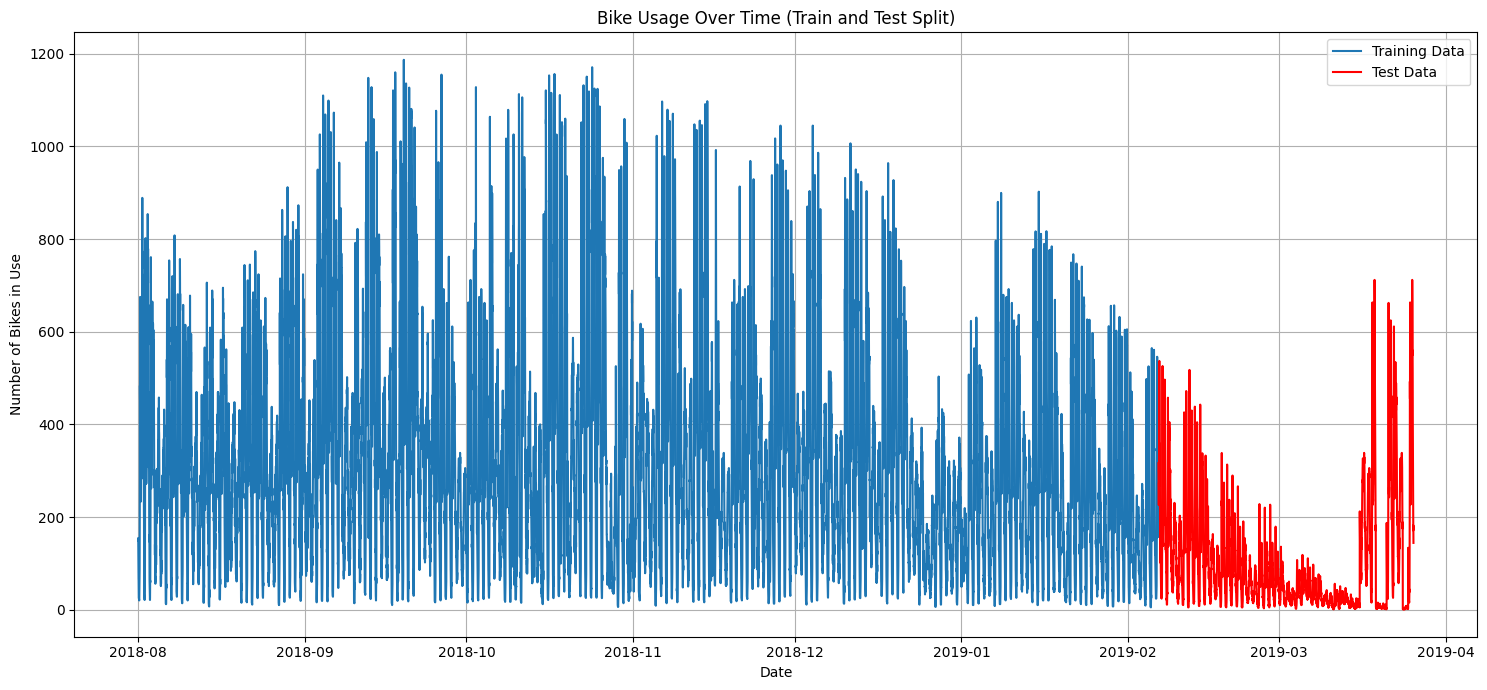

In [8]:
# Plot the time series data
print("\nPlotting time series data...")
plt.figure(figsize=(15, 7))
plt.plot(df_train.index, df_train['bikesInUsage_imputed'], label='Training Data')
plt.plot(df_test.index, df_test['bikesInUsage_imputed'], label='Test Data', color='red')
plt.title('Bike Usage Over Time (Train and Test Split)')
plt.xlabel('Date')
plt.ylabel('Number of Bikes in Use')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [10]:
# Statistical summary
print("\nStatistical summary of the data:")
print(df['bikesInUsage_imputed'].describe())


Statistical summary of the data:
count    22752.000000
mean       257.357846
std        217.476655
min          1.000000
25%         70.641048
50%        214.500000
75%        386.189333
max       1187.000000
Name: bikesInUsage_imputed, dtype: float64



Analyzing daily patterns...


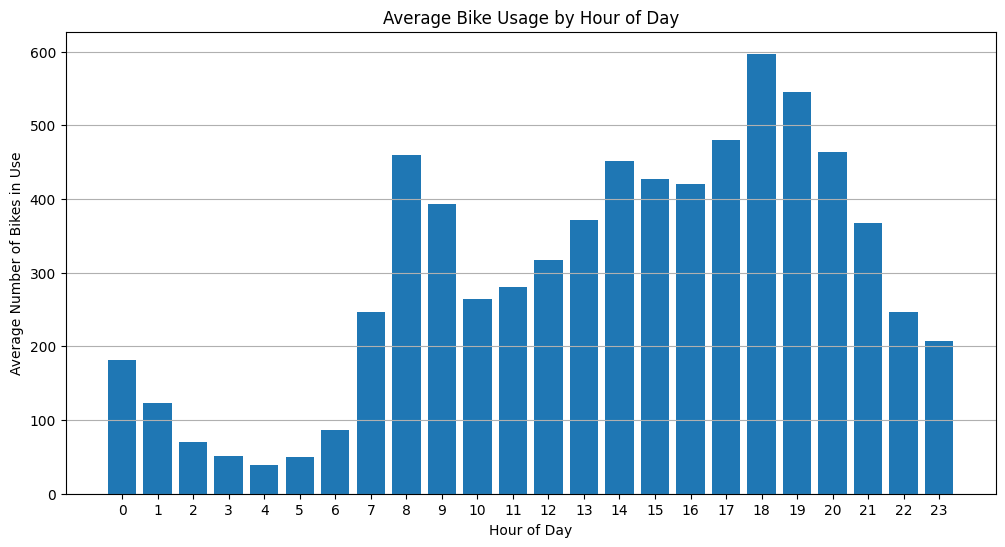

In [12]:
# Analyze daily patterns
print("\nAnalyzing daily patterns...")
df_train['hour'] = df_train.index.hour
hourly_avg = df_train.groupby('hour')['bikesInUsage_imputed'].mean()

plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Bike Usage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes in Use')
plt.xticks(range(0, 24))
plt.grid(True, axis='y')


Analyzing day of week patterns...


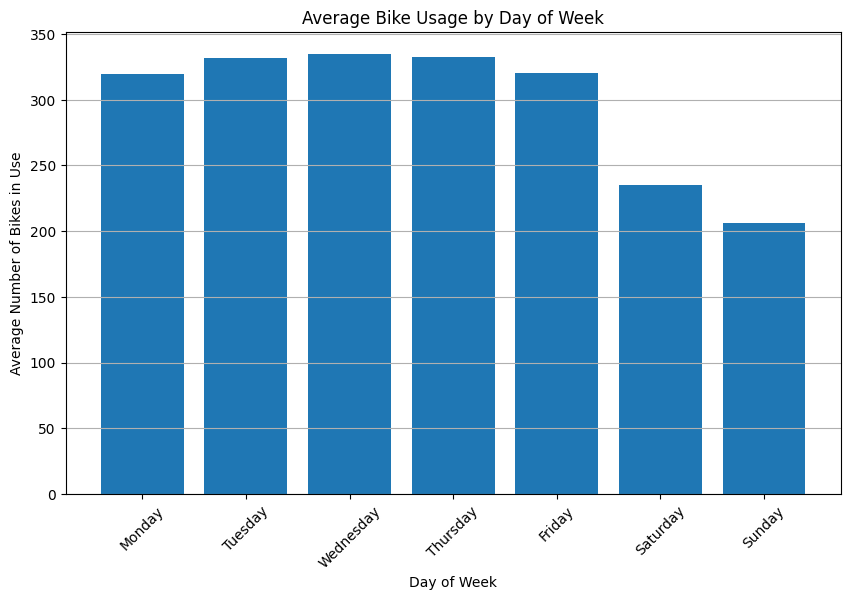

In [14]:
# Analyze day of week patterns
print("\nAnalyzing day of week patterns...")
df_train['day_of_week'] = df_train.index.dayofweek
weekday_avg = df_train.groupby('day_of_week')['bikesInUsage_imputed'].mean()

plt.figure(figsize=(10, 6))
plt.bar(weekday_avg.index, weekday_avg.values)
plt.title('Average Bike Usage by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Bikes in Use')
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.grid(True, axis='y')

In [15]:
# Clean up temporary columns
if 'hour' in df_train.columns:
    df_train.drop(['hour'], axis=1, inplace=True)
if 'day_of_week' in df_train.columns:
    df_train.drop(['day_of_week'], axis=1, inplace=True)

# STEP 4: STATIONARITY TESTING AND TRANSFORMATION

In [17]:
# Perform ADF test
print("\nAugmented Dickey-Fuller (ADF) Test:")
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"  - ADF Statistic: {result[0]:.4f}")
    print(f"  - p-value: {result[1]:.4f}")
    print(f"  - Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    if result[1] <= 0.05:
        print("  - Result: Reject null hypothesis, series is stationary")
    else:
        print("  - Result: Fail to reject null hypothesis, series is non-stationary")

adf_test(df_train['bikesInUsage_imputed'])


Augmented Dickey-Fuller (ADF) Test:
  - ADF Statistic: -21.4022
  - p-value: 0.0000
  - Critical Values:
    1%: -3.4307
    5%: -2.8617
    10%: -2.5669
  - Result: Reject null hypothesis, series is stationary


In [ ]:
# Perform KPSS test
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
def kpss_test(series):
    try:
        result = kpss(series.dropna())
        print(f"  - KPSS Statistic: {result[0]:.4f}")
        print(f"  - p-value: {result[1]:.4f}")
        print(f"  - Critical Values:")
        for key, value in result[3].items():
            print(f"    {key}: {value:.4f}")
        if result[1] <= 0.05:
            print("  - Result: Reject null hypothesis, series is non-stationary")
        else:
            print("  - Result: Fail to reject null hypothesis, series is stationary")
    except Exception as e:
        print(f"  - Error performing KPSS test: {e}")

kpss_test(df_train['bikesInUsage_imputed'])


Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
  - KPSS Statistic: 0.1415
  - p-value: 0.1000
  - Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  - Result: Fail to reject null hypothesis, series is stationary


C:\Users\alexc\AppData\Local\Temp\ipykernel_31608\141274283.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


In [19]:
# Differencing if necessary
print("\nApplying first differencing to make series stationary...")
df_train['diff1'] = df_train['bikesInUsage_imputed'].diff().dropna()

# Test stationarity of the differenced series
print("\nADF Test on Differenced Series:")
adf_test(df_train['diff1'])


Applying first differencing to make series stationary...

ADF Test on Differenced Series:
  - ADF Statistic: -27.5522
  - p-value: 0.0000
  - Critical Values:
    1%: -3.4307
    5%: -2.8617
    10%: -2.5669
  - Result: Reject null hypothesis, series is stationary


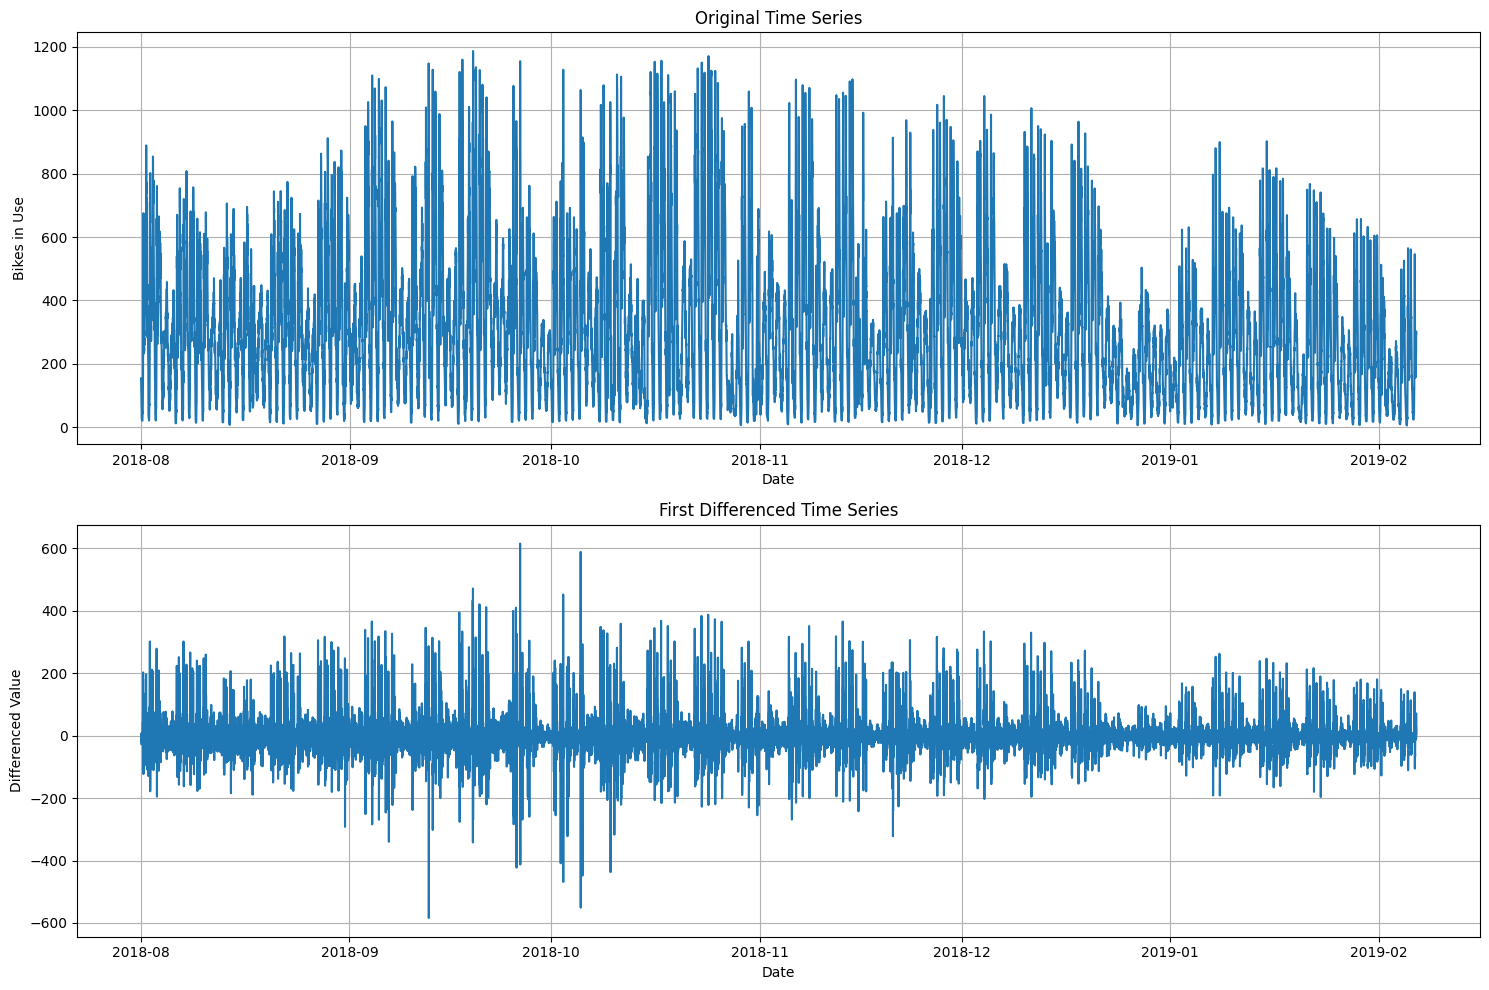

In [20]:
# Plot original vs differenced series
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_train['bikesInUsage_imputed'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Bikes in Use')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_train['diff1'])
plt.title('First Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)

plt.tight_layout()

MODEL 1: ARIMA (AutoRegressive Integrated Moving Average)

In [21]:
try:
    # Use the stationary series for ARIMA
    arima_model = ARIMA(df_train['bikesInUsage_imputed'].dropna(), order=(2, 1, 1))
    arima_fitted = arima_model.fit()
    
    print("ARIMA Model Summary:")
    print(f"  - AIC: {arima_fitted.aic:.2f}")
    print(f"  - BIC: {arima_fitted.bic:.2f}")
    print(f"  - Log Likelihood: {arima_fitted.llf:.2f}")
    
    # Model diagnostics
    print("\nARIMA Model Diagnostics:")
    residuals = arima_fitted.resid
    print(f"  - Residual Mean: {residuals.mean():.4f} (should be ~0)")
    print(f"  - Residual Std: {residuals.std():.4f}")
    # Skip Ljung-Box test as it's causing indexing issues
    # lb_test = arima_fitted.test_serial_correlation('ljungbox')
    # print(f"  - Ljung-Box test results: {lb_test}")
    
except Exception as e:
    print(f"ARIMA model training failed: {e}")
    arima_fitted = None

c:\Users\alexc\anaconda3\envs\clean_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
c:\Users\alexc\anaconda3\envs\clean_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
c:\Users\alexc\anaconda3\envs\clean_ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary:
  - AIC: 196028.89
  - BIC: 196060.12
  - Log Likelihood: -98010.44

ARIMA Model Diagnostics:
  - Residual Mean: 0.0147 (should be ~0)
  - Residual Std: 52.7968


In [22]:
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # Create hourly aggregated data for SARIMA (for faster processing)
    print("Creating hourly aggregated data for SARIMA...")
    df_train_hourly = df_train.resample('1H').mean()
    
    # SARIMA with daily seasonality (period=24 for hourly intervals)
    sarima_model = SARIMAX(df_train_hourly['bikesInUsage_imputed'].dropna(), 
                          order=(1, 1, 1), 
                          seasonal_order=(1, 1, 1, 24))
    sarima_fitted = sarima_model.fit(disp=False)
    
    print("SARIMA Model Summary:")
    print(f"  - AIC: {sarima_fitted.aic:.2f}")
    print(f"  - BIC: {sarima_fitted.bic:.2f}")
    print(f"  - Log Likelihood: {sarima_fitted.llf:.2f}")
    
    # Model diagnostics
    print("\nSARIMA Model Diagnostics:")
    residuals = sarima_fitted.resid
    print(f"  - Residual Mean: {residuals.mean():.4f} (should be ~0)")
    print(f"  - Residual Std: {residuals.std():.4f}")
    print(f"  - Training on hourly data instead of 15-min data for faster processing")
    
except Exception as e:
    print(f"SARIMA model training failed: {e}")
    sarima_fitted = None

Creating hourly aggregated data for SARIMA...
SARIMA Model Summary:
  - AIC: 50862.70
  - BIC: 50894.79
  - Log Likelihood: -25426.35

SARIMA Model Diagnostics:
  - Residual Mean: -0.1045 (should be ~0)
  - Residual Std: 66.9409
  - Training on hourly data instead of 15-min data for faster processing


# STEP 5: FEATURE ENGINEERING FOR MACHINE LEARNING MODELS

In [23]:
print("METHODOLOGY: Transform time series into ML-ready features")
print("PURPOSE: Enable machine learning models to capture temporal patterns")
print("="*60)

def create_features(df):
    """
    Create comprehensive features for machine learning models
    
    Feature Engineering Strategy:
    1. Temporal features: hour, day_of_week, month, etc.
    2. Cyclical encoding: sine/cosine for periodic patterns
    3. Lag features: previous values as predictors
    4. Rolling statistics: trend and volatility measures
    5. Difference features: rate of change indicators
    6. Binary indicators: weekend, business hours, peak times
    """
    print("  Creating comprehensive feature set...")
    df_features = df.copy()
    
    # =========================
    # 1. TIME-BASED FEATURES
    # =========================
    print("    - Time-based features (hour, day, month, etc.)")
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek  # 0=Monday, 6=Sunday
    df_features['month'] = df_features.index.month
    df_features['day_of_year'] = df_features.index.dayofyear
    df_features['quarter'] = df_features.index.quarter
    df_features['week_of_year'] = df_features.index.isocalendar().week
    
    # =========================
    # 2. CYCLICAL ENCODING
    # =========================
    # Why cyclical encoding? Hour 23 is closer to hour 0 than to hour 12
    # Sin/cos encoding preserves this cyclical relationship
    print("    - Cyclical encoding (sine/cosine transformations)")
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # =========================
    # 3. BINARY INDICATORS
    # =========================
    # Business logic: Different usage patterns for different time periods
    print("    - Binary indicators (weekend, business hours, peak times)")
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_business_hour'] = ((df_features['hour'] >= 8) & (df_features['hour'] <= 18)).astype(int)
    df_features['is_peak_hour'] = ((df_features['hour'].isin([7, 8, 9, 17, 18, 19]))).astype(int)
    
    # =========================
    # 4. LAG FEATURES
    # =========================
    # Use previous values to predict current value
    # Different lag periods capture different patterns
    print("    - Lag features (1, 2, 4, 8, 24, 96, weekly lags)")
    target_col = 'bikesInUsage_imputed'
    lag_periods = [1, 2, 3, 4, 8, 16, 24, 48, 96, 96*7]  # Various meaningful lags
    
    if target_col in df_features.columns:
        for lag in lag_periods:
            df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
    
    # =========================
    # 5. ROLLING STATISTICS
    # =========================
    # Capture trends and volatility over different time windows
    print("    - Rolling statistics (mean, std, min, max over multiple windows)")
    if target_col in df_features.columns:
        windows = [4, 8, 24, 96]  # 1hr, 2hr, 6hr, 24hr windows
        for window in windows:
            df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
            df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
            df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
            df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()
    
    # =========================
    # 6. DIFFERENCE FEATURES
    # =========================
    # Capture rate of change and momentum
    print("    - Difference features (1-period, daily, weekly differences)")
    if target_col in df_features.columns:
        df_features[f'{target_col}_diff_1'] = df_features[target_col].diff(1)
        df_features[f'{target_col}_diff_24'] = df_features[target_col].diff(24)  # Daily difference
        df_features[f'{target_col}_diff_96'] = df_features[target_col].diff(96)  # Same time yesterday
    
    return df_features

METHODOLOGY: Transform time series into ML-ready features
PURPOSE: Enable machine learning models to capture temporal patterns


In [24]:
# Apply feature engineering
print("Applying feature engineering to training and test datasets...")
df_train_features = create_features(df_train)
df_test_features = create_features(df_test)

Applying feature engineering to training and test datasets...
  Creating comprehensive feature set...
    - Time-based features (hour, day, month, etc.)
    - Cyclical encoding (sine/cosine transformations)
    - Binary indicators (weekend, business hours, peak times)
    - Lag features (1, 2, 4, 8, 24, 96, weekly lags)
    - Rolling statistics (mean, std, min, max over multiple windows)
    - Difference features (1-period, daily, weekly differences)
  Creating comprehensive feature set...
    - Time-based features (hour, day, month, etc.)
    - Cyclical encoding (sine/cosine transformations)
    - Binary indicators (weekend, business hours, peak times)
    - Lag features (1, 2, 4, 8, 24, 96, weekly lags)
    - Rolling statistics (mean, std, min, max over multiple windows)
    - Difference features (1-period, daily, weekly differences)


In [25]:
# Feature analysis
feature_cols = [col for col in df_train_features.columns if col not in 
               ['bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage',
                'bikesInUsage_imputed', 'electricalBikesInUsage_imputed', 'mechanicalBikesInUsage_imputed',
                'time_group', 'bikesInUsage_diff', 'electricalBikesInUsage_diff']]

print(f"\nFeature Engineering Summary:")
print(f"  - Total engineered features: {len(feature_cols)}")
print(f"  - Training set shape: {df_train_features.shape}")
print(f"  - Test set shape: {df_test_features.shape}")


Feature Engineering Summary:
  - Total engineered features: 45
  - Training set shape: (18201, 51)
  - Test set shape: (4551, 50)


In [26]:
# Categorize features for analysis
time_features = [f for f in feature_cols if any(x in f for x in ['hour', 'day', 'month', 'week', 'quarter', 'year'])]
lag_features = [f for f in feature_cols if 'lag' in f]
rolling_features = [f for f in feature_cols if 'rolling' in f]
diff_features = [f for f in feature_cols if 'diff' in f]
binary_features = [f for f in feature_cols if f.startswith('is_')]

print(f"\nFeature Categories:")
print(f"  - Time-based features: {len(time_features)}")
print(f"  - Lag features: {len(lag_features)}")
print(f"  - Rolling statistics: {len(rolling_features)}")
print(f"  - Difference features: {len(diff_features)}")
print(f"  - Binary indicators: {len(binary_features)}")


Feature Categories:
  - Time-based features: 15
  - Lag features: 10
  - Rolling statistics: 16
  - Difference features: 4
  - Binary indicators: 3


In [27]:
# Prepare data for ML model - remove target and identification columns
# First, create candidates for feature columns
candidate_features = [col for col in df_train_features.columns if col not in 
               ['bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage',
                'bikesInUsage_imputed', 'electricalBikesInUsage_imputed', 'total_bikes_imputed',
                'mechanicalBikesInUsage_imputed', 'time_group', 'hour', 'minute', 'dayofweek']]

# Make sure all features exist in both train and test data
feature_cols = [col for col in candidate_features if col in df_test_features.columns]

print(f"Note: Filtered out {len(candidate_features) - len(feature_cols)} features that don't exist in test data")

print(f"Selected {len(feature_cols)} features for Random Forest training:")
print("Feature categories being used:")
for category, features in [
    ("Time-based", [f for f in feature_cols if any(x in f for x in ['day', 'month', 'quarter', 'week', 'year'])]),
    ("Cyclical", [f for f in feature_cols if any(x in f for x in ['sin', 'cos'])]),
    ("Binary", [f for f in feature_cols if f.startswith('is_')]),
    ("Lag", [f for f in feature_cols if 'lag' in f]),
    ("Rolling", [f for f in feature_cols if 'rolling' in f]),
    ("Difference", [f for f in feature_cols if 'diff' in f])
]:
    print(f"  - {category}: {len(features)} features")

Note: Filtered out 1 features that don't exist in test data
Selected 43 features for Random Forest training:
Feature categories being used:
  - Time-based: 10 features
  - Cyclical: 7 features
  - Binary: 3 features
  - Lag: 10 features
  - Rolling: 16 features
  - Difference: 3 features


In [28]:
# Prepare training data
X_train = df_train_features[feature_cols].dropna()
y_train = df_train_features.loc[X_train.index, 'bikesInUsage_imputed']

# Prepare test data
# Safe indexing - only use features that were selected and exist in test data
X_test = df_test_features[feature_cols].fillna(method='ffill').fillna(method='bfill')
y_test = df_test_features['bikesInUsage_imputed'].values

print(f"\nData shapes:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {len(y_test)}")


Data shapes:
  - X_train: (17529, 43)
  - y_train: (17529,)
  - X_test: (4551, 43)
  - y_test: 4551


In [29]:
# Train Random Forest model
print(f"\nTraining Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=15,          # Maximum depth to prevent overfitting
    min_samples_split=10,  # Minimum samples required to split
    min_samples_leaf=5,    # Minimum samples required at leaf node
    random_state=42,       # For reproducibility
    n_jobs=-1             # Use all available cores
)

rf_model.fit(X_train, y_train)
print("Random Forest training completed!")


Training Random Forest model...
Random Forest training completed!


In [30]:
# Feature importance analysis
print(f"\nRandom Forest Feature Importance Analysis:")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<35} {row['importance']:.4f}")


Random Forest Feature Importance Analysis:
Top 10 Most Important Features:
   1. bikesInUsage_imputed_lag_1          0.5115
   2. bikesInUsage_imputed_rolling_max_4  0.3631
   3. bikesInUsage_imputed_rolling_mean_4 0.0719
   4. bikesInUsage_imputed_diff_1         0.0346
   5. bikesInUsage_imputed_rolling_min_4  0.0128
   6. bikesInUsage_imputed_lag_96         0.0014
   7. bikesInUsage_imputed_diff_24        0.0012
   8. bikesInUsage_imputed_lag_3          0.0009
   9. bikesInUsage_imputed_rolling_std_4  0.0006
  10. bikesInUsage_imputed_rolling_max_8  0.0004


In [31]:
# Model performance on training data
train_predictions = rf_model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"\nRandom Forest Training Performance:")
print(f"  - Training MAE: {train_mae:.2f}")
print(f"  - Training MSE: {train_mse:.2f}")
print(f"  - Training RMSE: {train_rmse:.2f}")


Random Forest Training Performance:
  - Training MAE: 1.94
  - Training MSE: 30.15
  - Training RMSE: 5.49


# STEP 7: MODEL EVALUATION AND COMPARISON

In [32]:
# Test data evaluation for Random Forest
print("\n--- Random Forest Model Evaluation ---")
test_predictions_rf = rf_model.predict(X_test)
test_mae_rf = mean_absolute_error(y_test, test_predictions_rf)
test_mse_rf = mean_squared_error(y_test, test_predictions_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_mape_rf = np.mean(np.abs((y_test - test_predictions_rf) / y_test)) * 100

print(f"Random Forest Test Performance:")
print(f"  - Test MAE:  {test_mae_rf:.2f}")
print(f"  - Test MSE:  {test_mse_rf:.2f}")
print(f"  - Test RMSE: {test_rmse_rf:.2f}")
print(f"  - Test MAPE: {test_mape_rf:.2f}%")


--- Random Forest Model Evaluation ---
Random Forest Test Performance:
  - Test MAE:  1.57
  - Test MSE:  13.30
  - Test RMSE: 3.65
  - Test MAPE: 19.76%


In [33]:
# Test data evaluation for ARIMA model
# Note: ARIMA predictions were made during model fitting above
# For comprehensive evaluation, we'll re-run predictions on test period
print("\n--- ARIMA Model Evaluation ---")
try:
    # Generate ARIMA forecasts for test period
    arima_forecast = arima_fitted.forecast(steps=len(y_test))
    test_mae_arima = mean_absolute_error(y_test, arima_forecast)
    test_mse_arima = mean_squared_error(y_test, arima_forecast)
    test_rmse_arima = np.sqrt(test_mse_arima)
    test_mape_arima = np.mean(np.abs((y_test - arima_forecast) / y_test)) * 100
    
    print(f"ARIMA(2,1,1) Test Performance:")
    print(f"  - Test MAE:  {test_mae_arima:.2f}")
    print(f"  - Test MSE:  {test_mse_arima:.2f}")
    print(f"  - Test RMSE: {test_rmse_arima:.2f}")
    print(f"  - Test MAPE: {test_mape_arima:.2f}%")
    
except Exception as e:
    print(f"ARIMA evaluation error: {e}")
    test_mae_arima = test_mse_arima = test_rmse_arima = test_mape_arima = float('inf')


--- ARIMA Model Evaluation ---
ARIMA(2,1,1) Test Performance:
  - Test MAE:  221.66
  - Test MSE:  56056.06
  - Test RMSE: 236.76
  - Test MAPE: 1813.79%


In [41]:
# Test data evaluation for SARIMA model
print("\n--- SARIMA Model Evaluation ---")
try:
    # Create hourly test data for SARIMA evaluation
    df_test_hourly = df_test.resample('1H').mean()
    y_test_hourly = df_test_hourly['bikesInUsage_imputed']
    
    # Convert test data period length from 15-min to hourly intervals
    hourly_steps = len(df_test_hourly)  # Number of hours in test period
    print(f"  - Test period: {hourly_steps} hours")
    
    # Generate SARIMA forecasts for hourly test period
    sarima_forecast_hourly = sarima_fitted.forecast(steps=hourly_steps)
    
    # OPTION 1: Compare on hourly data directly
    test_mae_sarima_hourly = mean_absolute_error(y_test_hourly, sarima_forecast_hourly)
    test_mse_sarima_hourly = mean_squared_error(y_test_hourly, sarima_forecast_hourly)
    test_rmse_sarima_hourly = np.sqrt(test_mse_sarima_hourly)
    test_mape_sarima_hourly = np.mean(np.abs((y_test_hourly - sarima_forecast_hourly) / y_test_hourly)) * 100
    
    # OPTION 2: Upsample SARIMA hourly predictions to 15-minute intervals
    # Create a Series with the hourly forecasts
    hourly_forecast_series = pd.Series(
        data=sarima_forecast_hourly,
        index=df_test_hourly.index
    )
    
    # Resample to 15-minute intervals using time interpolation (safer than cubic spline)
    forecast_resampled = hourly_forecast_series.resample('15T').interpolate(method='time')

    # Align with actual 15-min test period and safely fill any remaining gaps
    aligned_forecast = forecast_resampled.reindex(df_test.index).ffill().bfill()
    
    # Calculate metrics on 15-minute data
    y_test_15min = df_test['bikesInUsage_imputed']
    test_mae_sarima = mean_absolute_error(y_test_15min, aligned_forecast)
    test_mse_sarima = mean_squared_error(y_test_15min, aligned_forecast)
    test_rmse_sarima = np.sqrt(test_mse_sarima)
    test_mape_sarima = np.mean(np.abs((y_test_15min - aligned_forecast) / y_test_15min)) * 100
    
    # Store both sets of metrics, but use the 15-min ones as default for comparison
    print(f"SARIMA(1,1,1)(1,1,1,24) Test Performance (Hourly):")
    print(f"  - Hourly Test MAE:  {test_mae_sarima_hourly:.2f}")
    print(f"  - Hourly Test MSE:  {test_mse_sarima_hourly:.2f}")
    print(f"  - Hourly Test RMSE: {test_rmse_sarima_hourly:.2f}")
    print(f"  - Hourly Test MAPE: {test_mape_sarima_hourly:.2f}%")
    
    print(f"\nSARIMA(1,1,1)(1,1,1,24) Test Performance (Upsampled to 15-min):")
    print(f"  - 15-min Test MAE:  {test_mae_sarima:.2f}")
    print(f"  - 15-min Test MSE:  {test_mse_sarima:.2f}")
    print(f"  - 15-min Test RMSE: {test_rmse_sarima:.2f}")
    print(f"  - 15-min Test MAPE: {test_mape_sarima:.2f}%")
    
except Exception as e:
    print(f"SARIMA evaluation error: {e}")
    test_mae_sarima = test_mse_sarima = test_rmse_sarima = test_mape_sarima = float('inf')
    test_mae_sarima_hourly = test_mse_sarima_hourly = test_rmse_sarima_hourly = test_mape_sarima_hourly = float('inf')


--- SARIMA Model Evaluation ---
  - Test period: 1138 hours
SARIMA(1,1,1)(1,1,1,24) Test Performance (Hourly):
  - Hourly Test MAE:  132.76
  - Hourly Test MSE:  25178.39
  - Hourly Test RMSE: 158.68
  - Hourly Test MAPE: 798.84%

SARIMA(1,1,1)(1,1,1,24) Test Performance (Upsampled to 15-min):
  - 15-min Test MAE:  125.99
  - 15-min Test MSE:  22820.33
  - 15-min Test RMSE: 151.06
  - 15-min Test MAPE: 819.07%


In [42]:
# Model comparison summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

# Create comparison DataFrame for easy analysis
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'ARIMA(2,1,1)', 'SARIMA(1,1,1)(1,1,1,24)'],
    'Test_MAE': [test_mae_rf, test_mae_arima, test_mae_sarima],
    'Test_MSE': [test_mse_rf, test_mse_arima, test_mse_sarima],
    'Test_RMSE': [test_rmse_rf, test_rmse_arima, test_rmse_sarima],
    'Test_MAPE': [test_mape_rf, test_mape_arima, test_mape_sarima]
})

model_comparison


MODEL COMPARISON SUMMARY


,Model,Test_MAE,Test_MSE,Test_RMSE,Test_MAPE
0,Random Forest,1.573958,13.303833,3.647442,19.755089
1,"ARIMA(2,1,1)",221.656247,56056.056772,236.761603,1813.785160
2,"SARIMA(1,1,1)(1,1,1,24)",125.994811,22820.331602,151.063998,819.073054


In [44]:
# Alternative comparison using hourly metrics for SARIMA (for reference)
model_comparison_hourly = pd.DataFrame({
    'Model': ['Random Forest (15-min)', 'ARIMA(2,1,1) (15-min)', 'SARIMA(1,1,1)(1,1,1,24) (Hourly)'],
    'Test_MAE': [test_mae_rf, test_mae_arima, test_mae_sarima_hourly],
    'Test_MSE': [test_mse_rf, test_mse_arima, test_mse_sarima_hourly],
    'Test_RMSE': [test_rmse_rf, test_rmse_arima, test_rmse_sarima_hourly],
    'Test_MAPE': [test_mape_rf, test_mape_arima, test_mape_sarima_hourly]
})


model_comparison_hourly

,Model,Test_MAE,Test_MSE,Test_RMSE,Test_MAPE
0,Random Forest (15-min),1.573958,13.303833,3.647442,19.755089
1,"ARIMA(2,1,1) (15-min)",221.656247,56056.056772,236.761603,1813.785160
2,"SARIMA(1,1,1)(1,1,1,24) (Hourly)",132.764547,25178.391846,158.677005,798.835616


In [45]:
# Sort by RMSE (primary metric for comparison)
model_comparison = model_comparison.sort_values('Test_RMSE')

print("Performance Ranking (Best to Worst by RMSE):")
for i, (_, row) in enumerate(model_comparison.iterrows(), 1):
    print(f"{i}. {row['Model']:<25} RMSE: {row['Test_RMSE']:.2f}, "
          f"MAE: {row['Test_MAE']:.2f}, MAPE: {row['Test_MAPE']:.2f}%")

# Identify best model
best_model_name = model_comparison.iloc[0]['Model']
best_rmse = model_comparison.iloc[0]['Test_RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Best Test RMSE: {best_rmse:.2f}")

Performance Ranking (Best to Worst by RMSE):
1. Random Forest             RMSE: 3.65, MAE: 1.57, MAPE: 19.76%
2. SARIMA(1,1,1)(1,1,1,24)   RMSE: 151.06, MAE: 125.99, MAPE: 819.07%
3. ARIMA(2,1,1)              RMSE: 236.76, MAE: 221.66, MAPE: 1813.79%

🏆 BEST MODEL: Random Forest
   Best Test RMSE: 3.65


# STEP 8: FUTURE FORECASTING AND PREDICTIONS

In [46]:
print(f"Generating future forecasts using the best model: {best_model_name}")

# Define forecast horizon (e.g., next 7 days = 7 * 96 = 672 intervals for 15-min data)
forecast_horizon_15min = 7 * 96  # 7 days ahead at 15-min intervals
forecast_horizon_hourly = 7 * 24  # 7 days ahead at hourly intervals
print(f"Forecast horizon: {forecast_horizon_15min} intervals (15-min) or {forecast_horizon_hourly} intervals (hourly) = 7 days")

if best_model_name == 'Random Forest':
    print("\nGenerating Random Forest predictions for future periods...")
    
    # For Random Forest, we need to create features for future time periods
    # Create future datetime index
    last_datetime = df_test.index[-1]
    future_dates = pd.date_range(
        start=last_datetime + pd.Timedelta(minutes=15),
        periods=forecast_horizon_15min,  # Random Forest uses 15-min intervals
        freq='15T'
    )
    
    # Create DataFrame for future periods with the same columns as the original data
    # This ensures we have all needed columns for proper feature engineering
    future_df = pd.DataFrame(index=future_dates)
    future_df['total_bikes'] = np.nan  # Unknown target values
    
    # Add electrical and mechanical bikes columns which are needed for feature creation
    future_df['electrical_bikes'] = np.nan
    future_df['mechanical_bikes'] = np.nan
    
    # Apply feature engineering to future data
    print("Creating features for future time periods...")
    future_features = create_features(future_df)
    
    # Handle missing values in future features
    future_features = future_features.fillna(method='ffill').fillna(0)
    
    # CRITICAL: Only use exact columns that were used during model training
    print("Ensuring feature consistency with training data...")
    missing_cols = set(feature_cols) - set(future_features.columns)
    extra_cols = set(future_features.columns) - set(feature_cols)
    
    if missing_cols:
        print(f"  Warning: Missing columns in future data: {missing_cols}")
        # Add missing columns with zeros
        for col in missing_cols:
            future_features[col] = 0
    
    if extra_cols:
        print(f"  Removing extra columns not used in training: {extra_cols}")
        # Drop any columns not used during training
        future_features = future_features.drop(columns=list(extra_cols))
    
    # Ensure column order matches exactly what model was trained on
    future_features = future_features[feature_cols]
    
    # Generate predictions
    try:
        print("Generating Random Forest predictions...")
        future_predictions = rf_model.predict(future_features)
        
        print(f"\nFuture Predictions Summary (Random Forest):")
        print(f"  - Mean predicted usage: {np.mean(future_predictions):.2f} bikes")
        print(f"  - Min predicted usage:  {np.min(future_predictions):.2f} bikes")
        print(f"  - Max predicted usage:  {np.max(future_predictions):.2f} bikes")
        print(f"  - Std predicted usage:  {np.std(future_predictions):.2f} bikes")
        
        # Create future predictions DataFrame
        future_results = pd.DataFrame({
            'datetime': future_dates,
            'predicted_total_bikes': future_predictions
        })
        
        print(f"\nFirst 24 hours of predictions:")
        print(future_results.head(96))  # First 96 intervals = 24 hours
        
    except Exception as e:
        print(f"Error generating Random Forest predictions: {e}")

elif 'ARIMA' in best_model_name:
    print(f"\nGenerating {best_model_name} predictions for future periods...")
    
    try:
        if best_model_name == 'ARIMA(2,1,1)':
            # ARIMA uses 15-min data
            future_forecast = arima_fitted.forecast(steps=forecast_horizon_15min)
            
            # Create future dates for 15-min intervals
            last_datetime = df_test.index[-1]
            future_dates = pd.date_range(
                start=last_datetime + pd.Timedelta(minutes=15),
                periods=forecast_horizon_15min,
                freq='15T'
            )
            
        else:  # SARIMA
            # SARIMA uses hourly data
            future_forecast_hourly = sarima_fitted.forecast(steps=forecast_horizon_hourly)
            
            # Create hourly dates
            last_hour_datetime = df_test.resample('1H').mean().index[-1]
            future_dates_hourly = pd.date_range(
                start=last_hour_datetime + pd.Timedelta(hours=1),
                periods=forecast_horizon_hourly,
                freq='1H'
            )
            
            # Create hourly forecast Series
            hourly_forecast_series = pd.Series(
                data=future_forecast_hourly,
                index=future_dates_hourly
            )
            
            # Upsample hourly predictions to 15-min resolution using interpolation
            # Create 15-min date range spanning the same period
            future_dates = pd.date_range(
                start=last_datetime + pd.Timedelta(minutes=15),
                periods=forecast_horizon_15min,
                freq='15T'
            )
            
            # Create an empty series with the 15-min dates
            forecast_resampled = pd.Series(index=future_dates)
            
            # Reindex the hourly forecast to 15-min and interpolate
            future_forecast = hourly_forecast_series.reindex(forecast_resampled.index, method='nearest')
            
            # For missing values (at the edges), use cubic interpolation
            future_forecast = future_forecast.interpolate(method='cubic')
            
            print(f"  - Note: SARIMA forecasts were generated at hourly intervals and upsampled to 15-min intervals")
        
        print(f"\nFuture Predictions Summary ({best_model_name}):")
        print(f"  - Mean predicted usage: {np.mean(future_forecast):.2f} bikes")
        print(f"  - Min predicted usage:  {np.min(future_forecast):.2f} bikes")
        print(f"  - Max predicted usage:  {np.max(future_forecast):.2f} bikes")
        print(f"  - Std predicted usage:  {np.std(future_forecast):.2f} bikes")
        
        future_results = pd.DataFrame({
            'datetime': future_dates,
            'predicted_total_bikes': future_forecast
        })
        
        print(f"\nFirst 24 hours of predictions:")
        print(future_results.head(96))  # First 96 intervals = 24 hours
        
    except Exception as e:
        print(f"Error generating {best_model_name} predictions: {e}")

Generating future forecasts using the best model: Random Forest
Forecast horizon: 672 intervals (15-min) or 168 intervals (hourly) = 7 days

Generating Random Forest predictions for future periods...
Creating features for future time periods...
  Creating comprehensive feature set...
    - Time-based features (hour, day, month, etc.)
    - Cyclical encoding (sine/cosine transformations)
    - Binary indicators (weekend, business hours, peak times)
    - Lag features (1, 2, 4, 8, 24, 96, weekly lags)
    - Rolling statistics (mean, std, min, max over multiple windows)
    - Difference features (1-period, daily, weekly differences)
Ensuring feature consistency with training data...
  Removing extra columns not used in training: {'electrical_bikes', 'hour', 'mechanical_bikes', 'total_bikes'}
Generating Random Forest predictions...

Future Predictions Summary (Random Forest):
  - Mean predicted usage: 6.21 bikes
  - Min predicted usage:  6.08 bikes
  - Max predicted usage:  6.43 bikes
  - 

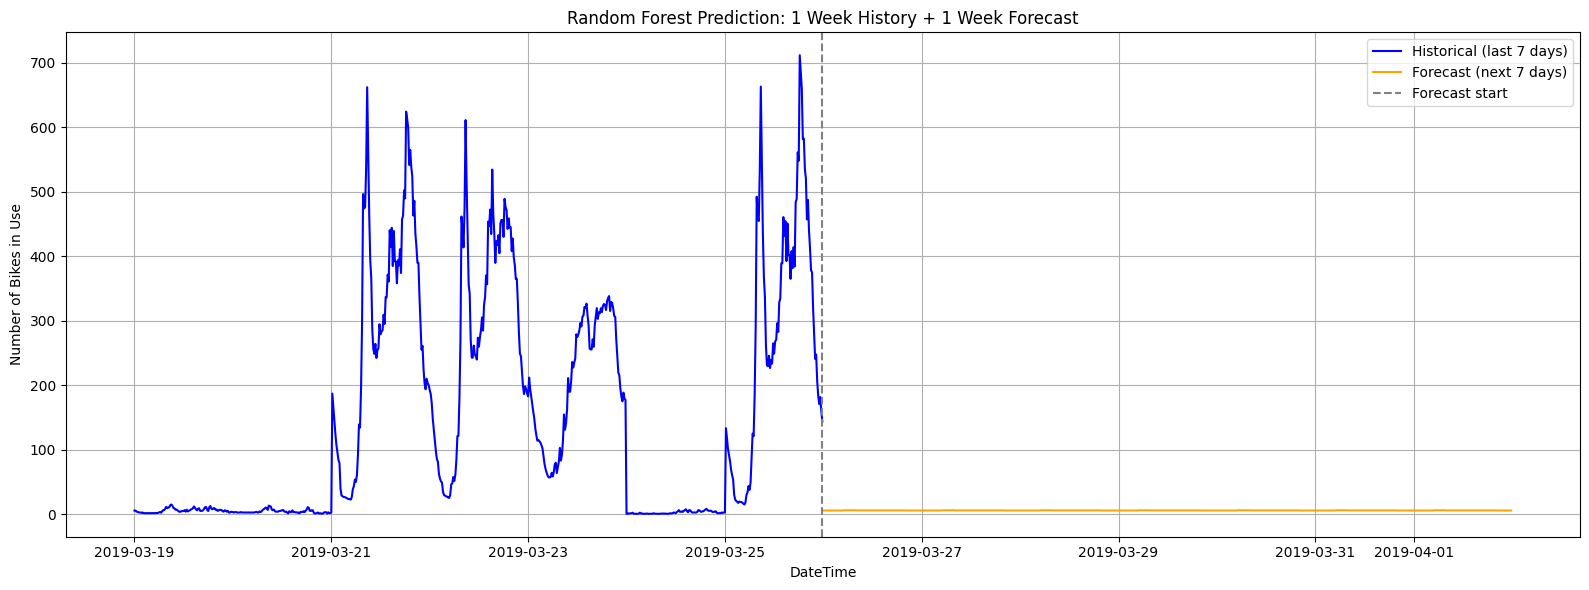

In [47]:
# Plot 1 week of history + 1 week of future predictions
import matplotlib.pyplot as plt

# Get 1 week of historical 15-min data
history_window = 7 * 96  # 1 week of 15-min intervals
history_data = df_test['bikesInUsage_imputed'].dropna().iloc[-history_window:]

# Combine historical and forecast data
plot_df = pd.DataFrame({
    'datetime': pd.concat([history_data.index.to_series(), future_results['datetime']]),
    'bikes_in_use': pd.concat([history_data, future_results['predicted_total_bikes']])
})
plot_df.set_index('datetime', inplace=True)

# Plot
plt.figure(figsize=(16, 6))
plt.plot(history_data.index, history_data, label='Historical (last 7 days)', color='blue')
plt.plot(future_results['datetime'], future_results['predicted_total_bikes'], label='Forecast (next 7 days)', color='orange')
plt.axvline(x=history_data.index[-1], color='gray', linestyle='--', label='Forecast start')
plt.title(f"{best_model_name} Prediction: 1 Week History + 1 Week Forecast")
plt.xlabel("DateTime")
plt.ylabel("Number of Bikes in Use")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
print(f"\n🎯 KEY FINDINGS:")
print(f"• Best performing model: {best_model_name}")
print(f"• Best test RMSE: {best_rmse:.2f}")
print(f"• Dataset covers {len(df)} intervals of bike usage data")
print(f"• Training period: {df_train.index[0]} to {df_train.index[-1]}")
print(f"• Test period: {df_test.index[0]} to {df_test.index[-1]}")

print(f"\n💡 RECOMMENDATIONS:")
print(f"1. Use {best_model_name} for production forecasting")
print(f"2. Monitor model performance and retrain periodically")
print(f"3. Consider ensemble methods combining multiple models")
print(f"4. Implement real-time model updating as new data arrives")
print(f"5. Add external features (weather, events) for improved accuracy")

print(f"\n📈 BUSINESS IMPACT:")
print(f"• Enables proactive bike redistribution planning")
print(f"• Optimizes resource allocation across stations")
print(f"• Improves customer satisfaction through availability")
print(f"• Reduces operational costs through efficient planning")

print("\n🔄 Script execution completed successfully!")
print("All 8 steps of the time series modeling methodology have been implemented.")


🎯 KEY FINDINGS:
• Best performing model: Random Forest
• Best test RMSE: 3.65
• Dataset covers 22752 intervals of bike usage data
• Training period: 2018-08-01 00:00:00 to 2019-02-06 14:00:00
• Test period: 2019-02-06 14:15:00 to 2019-03-25 23:45:00

💡 RECOMMENDATIONS:
1. Use Random Forest for production forecasting
2. Monitor model performance and retrain periodically
3. Consider ensemble methods combining multiple models
4. Implement real-time model updating as new data arrives
5. Add external features (weather, events) for improved accuracy

📈 BUSINESS IMPACT:
• Enables proactive bike redistribution planning
• Optimizes resource allocation across stations
• Improves customer satisfaction through availability
• Reduces operational costs through efficient planning

🔄 Script execution completed successfully!
All 8 steps of the time series modeling methodology have been implemented.
